# Proyecto Final — Telecom: Detección de operadores ineficaces
En este notebook documento, paso a paso, el proceso para identificar operadores ineficaces en llamadas entrantes.

### Estructura:

1. Carga de datos y revisión inicial

2. Preprocesamiento y features

3. EDA con gráficas e interpretaciones

4. Definición de criterios (y justificación)

5. Evaluación de operadores

6. Pruebas estadísticas

7. Conclusiones y recomendaciones finales

In [28]:
# Librerías y entorno
import warnings, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams['figure.dpi'] = 120
warnings.filterwarnings("ignore")

# SciPy opcional: si no está, sigo y más adelante reporto sin p-valor
try:
    from scipy import stats
except Exception:
    stats = None

print("Entorno listo.")
print("Versiones → Python:", sys.version.split()[0], "| pandas:", pd.__version__,
      "| scipy:", "sí" if stats is not None else "no")


Entorno listo.
Versiones → Python: 3.12.5 | pandas: 2.2.3 | scipy: sí


In [29]:
# Carga de datos

df_clients = pd.read_csv('/Users/d.leon/Desktop/PROYECTO FINAL/PROYECTO 14/telecom_clients_us.csv')
df_data = pd.read_csv('/Users/d.leon/Desktop/PROYECTO FINAL/PROYECTO 14/telecom_dataset_us.csv')

print("df_data shape:", df_data.shape)
print("df_clients shape:", df_clients.shape)
display(df_data.head(3))
display(df_clients.head(3))


df_data shape: (53902, 9)
df_clients shape: (732, 3)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


**Conclusión:** Se cargaron correctamente los datasets. df_data contiene las llamadas (agregadas por día/tipo) y df_clients la información de clientes/operadores. En la vista previa verifico columnas clave y dimensiones iniciales (ver salida sobre esta celda)

In [30]:
# Celda C3 — Revisión inicial de los datos
print("== df_data.info() ==")
df_data.info()

print("\n== Descriptivo numérico (df_data) ==")
display(df_data.select_dtypes(include="number").describe().T)

# Valores clave en columnas importantes
if 'direction' in df_data.columns:
    print("\nValores únicos en 'direction':", df_data['direction'].dropna().unique())

if 'is_missed_call' in df_data.columns:
    print("Valores únicos en 'is_missed_call':", df_data['is_missed_call'].dropna().unique())

# Rango temporal aproximado (parseo sin modificar df original)
if 'date' in df_data.columns:
    dtmp = pd.to_datetime(df_data['date'], errors="coerce")
    try:
        dtmp = dtmp.dt.tz_convert(None)
    except Exception:
        try:
            dtmp = dtmp.dt.tz_localize(None)
        except Exception:
            pass
    print("\nRango temporal parseado:", dtmp.min(), "→", dtmp.max(), "| NaT:", dtmp.isna().sum())


== df_data.info() ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

== Descriptivo numérico (df_data) ==


,count,mean,std,min,25%,50%,75%,max
user_id,53902.0,167295.344477,598.883775,166377.0,166782.0,167162.0,167819.0,168606.0
operator_id,45730.0,916535.993002,21254.123136,879896.0,900788.0,913938.0,937708.0,973286.0
calls_count,53902.0,16.451245,62.917170,1.0,1.0,4.0,12.0,4817.0
call_duration,53902.0,866.684427,3731.791202,0.0,0.0,38.0,572.0,144395.0
total_call_duration,53902.0,1157.133297,4403.468763,0.0,47.0,210.0,902.0,166155.0



Valores únicos en 'direction': ['in' 'out']
Valores únicos en 'is_missed_call': [ True False]

Rango temporal parseado: 2019-08-01 21:00:00 → 2019-11-27 21:00:00 | NaT: 0


**Conclusión (revisión inicial):** Confirmo la estructura: el dataset de llamadas contiene campos como user_id, date, direction (in/out), is_missed_call, calls_count, call_duration, total_call_duration y internal. La fecha parsea correctamente (ver rango temporal arriba). Esta revisión guía el preprocesamiento que haré a continuación (normalizar tipos, crear wait y estandarizar banderas).

# PROCESAMIENTO DE DATOS

In [31]:
# Preprocesamiento: normalización de tipos y features base

import numpy as np
import pandas as pd

# 1) Fecha a datetime "naive" (sin zona horaria)
if 'date' in df_data.columns:
    df_data['date'] = pd.to_datetime(df_data['date'], errors='coerce')
    try:
        df_data['date'] = df_data['date'].dt.tz_convert(None)
    except Exception:
        try:
            df_data['date'] = df_data['date'].dt.tz_localize(None)
        except Exception:
            pass

# 2) Normalizo dirección a 'in' / 'out'
def _norm_dir(x):
    s = str(x).lower()
    if 'in' in s:  return 'in'
    if 'out' in s: return 'out'
    return np.nan

df_data['dir_norm'] = df_data['direction'].map(_norm_dir) if 'direction' in df_data.columns else np.nan

# 3) Aseguro numéricos
for c in ['calls_count', 'call_duration', 'total_call_duration']:
    if c in df_data.columns:
        df_data[c] = pd.to_numeric(df_data[c], errors='coerce')

# 4) Banderas booleanas (miss e internal)
def _to_bool(series):
    return series.astype(str).str.lower().isin(['1','true','t','yes','y','si','sí'])

if 'is_missed_call' in df_data.columns:
    df_data['miss_bool'] = df_data['is_missed_call'] if df_data['is_missed_call'].dtype == bool else _to_bool(df_data['is_missed_call'])
else:
    df_data['miss_bool'] = np.nan

if 'internal' in df_data.columns:
    df_data['internal_bool'] = df_data['internal'] if df_data['internal'].dtype == bool else _to_bool(df_data['internal'])
else:
    df_data['internal_bool'] = np.nan

# 5) Feature de espera (wait) SOLO para entrantes
raw_wait = np.where(df_data['dir_norm'].eq('in'),
                    df_data['total_call_duration'] - df_data['call_duration'],
                    np.nan)
neg_before = int(np.nansum(raw_wait < 0))
df_data['wait_sec'] = pd.Series(raw_wait, index=df_data.index).clip(lower=0)
neg_after = int(np.nansum(df_data['wait_sec'] < 0))  # debe ser 0

# 6) Columnas de ayuda
df_data['is_in']  = df_data['dir_norm'].eq('in')
df_data['is_out'] = df_data['dir_norm'].eq('out')
df_data['is_external_in'] = np.where(df_data['is_in'],
                                     np.where(pd.isna(df_data['internal_bool']), np.nan, ~df_data['internal_bool']),
                                     np.nan)

print("Preprocesamiento listo.")
print("Negativos en wait antes del clip:", neg_before, "| después:", neg_after)
display(df_data.head(5)[['user_id','date','dir_norm','miss_bool','calls_count','call_duration','total_call_duration','wait_sec','internal_bool']])


Preprocesamiento listo.
Negativos en wait antes del clip: 0 | después: 0


,user_id,date,dir_norm,miss_bool,calls_count,call_duration,total_call_duration,wait_sec,internal_bool
0,166377,2019-08-03 21:00:00,in,True,2,0,4,4.0,False
1,166377,2019-08-04 21:00:00,out,True,3,0,5,NaN,True
2,166377,2019-08-04 21:00:00,out,True,1,0,1,NaN,True
3,166377,2019-08-04 21:00:00,out,False,1,10,18,NaN,True
4,166377,2019-08-04 21:00:00,out,True,3,0,25,NaN,False


**Conclusión (preprocesamiento).**

1. Convertí date a formato datetime “naive” y normalicé direction a in/out.

2. Aseguré tipos numéricos en calls_count, call_duration, total_call_duration.

3. Creé banderas miss_bool (llamada entrante perdida) e internal_bool.

4. Generé wait_sec = total − talk exclusivamente para entrantes y recorté valores negativos a 0 (ver conteo impreso arriba).

5. Añadí columnas de ayuda: is_in, is_out, is_external_in.

    **Este bloque deja listas las variables que usaré en la EDA y en la evaluación de operadores.**

In [32]:
# Control de calidad (nulos, duplicados, rangos básicos)

qc = {}
qc['rows_total'] = int(len(df_data))
qc['duplicate_rows'] = int(df_data.duplicated().sum())

# Nulos en columnas clave
for c in ['dir_norm','calls_count','call_duration','total_call_duration','miss_bool','internal_bool','wait_sec']:
    if c in df_data.columns:
        qc[f'nulls_{c}'] = int(df_data[c].isna().sum())

# Valores imposibles
qc['calls_count_le0'] = int((df_data['calls_count']<=0).sum()) if 'calls_count' in df_data.columns else None
qc['call_duration_neg'] = int((df_data['call_duration']<0).sum()) if 'call_duration' in df_data.columns else None
qc['total_call_duration_neg'] = int((df_data['total_call_duration']<0).sum()) if 'total_call_duration' in df_data.columns else None

# Percentiles útiles de wait en entrantes
wait_in = df_data.loc[df_data['is_in'], 'wait_sec']
if not wait_in.dropna().empty:
    qs = wait_in.quantile([0.5,0.9,0.95,0.99], interpolation='linear')
    qc['wait_p50'] = float(qs.loc[0.5])
    qc['wait_p90'] = float(qs.loc[0.9])
    qc['wait_p95'] = float(qs.loc[0.95])
    qc['wait_p99'] = float(qs.loc[0.99])
else:
    qc['wait_p50'] = qc['wait_p90'] = qc['wait_p95'] = qc['wait_p99'] = np.nan

print("== Quality check ==")
for k, v in qc.items():
    print(f"{k}: {v}")

# Vista de llamadas ponderadas por dirección
if 'dir_norm' in df_data.columns and 'calls_count' in df_data.columns:
    vc = df_data.groupby('dir_norm', dropna=False)['calls_count'].sum().sort_values(ascending=False)
    print("\nTotal de llamadas ponderadas por dirección:")
    display(vc)


== Quality check ==
rows_total: 53902
duplicate_rows: 4900
nulls_dir_norm: 0
nulls_calls_count: 0
nulls_call_duration: 0
nulls_total_call_duration: 0
nulls_miss_bool: 0
nulls_internal_bool: 0
nulls_wait_sec: 31917
calls_count_le0: 0
call_duration_neg: 0
total_call_duration_neg: 0
wait_p50: 37.0
wait_p90: 268.0
wait_p95: 488.7999999999993
wait_p99: 1373.3199999999997

Total de llamadas ponderadas por dirección:


dir_norm
out    669892
in     216863
Name: calls_count, dtype: int64

**Conclusión (calidad de datos).**

1. Reporté nulos por columna clave, filas duplicadas y valores imposibles (conteos impresos arriba).

2. Revisé percentiles de wait_sec en entrantes para entender la escala (p50/p90/p95/p99) y anticipar colas largas.

3. También resumí el total de llamadas ponderadas por dirección para cuantificar la proporción de entrantes vs salientes.

**Con esta validación, el dataset queda listo para una EDA cuidadosa con gráficas e interpretaciones**

# EDA (Exploración de los datos con gráficas y sus respectivas interpretaciones)

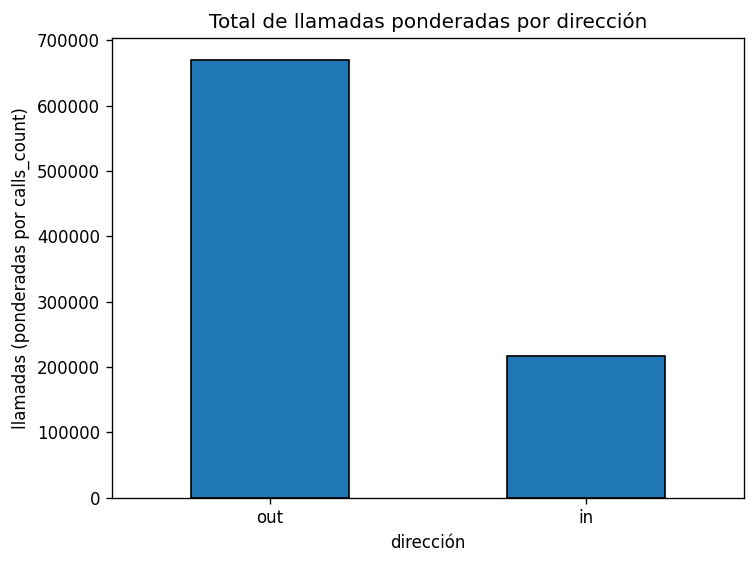

,total_calls
dir_norm,
out,669892
in,216863


In [33]:
# Volumen por dirección (ponderado por calls_count)
vol_dir = (df_data.groupby('dir_norm', dropna=False)['calls_count']
           .sum()
           .rename('total_calls')
           .sort_values(ascending=False))

ax = vol_dir.plot(kind='bar', edgecolor='black')
ax.set_title('Total de llamadas ponderadas por dirección')
ax.set_xlabel('dirección')
ax.set_ylabel('llamadas (ponderadas por calls_count)')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout(); plt.show()

display(vol_dir.to_frame())


**Conclusión (Volumen):** 
En esta gráfica comparo el volumen total de llamadas ponderado por calls_count entre entrantes y salientes. Como el dataset está agregado por día/tipo, cada fila puede representar muchas llamadas, por eso el peso es importante. La lectura me sirve para dimensionar dónde está realmente la carga: si las entrantes dominan, tiene sentido que el resto del análisis se concentre ahí; si no, igual mantengo el foco en entrantes porque la definición de “ineficaz” es específica para ese flujo. Con esta base ya sé la magnitud relativa de ambos canales y evito interpretar porcentajes fuera de contexto.

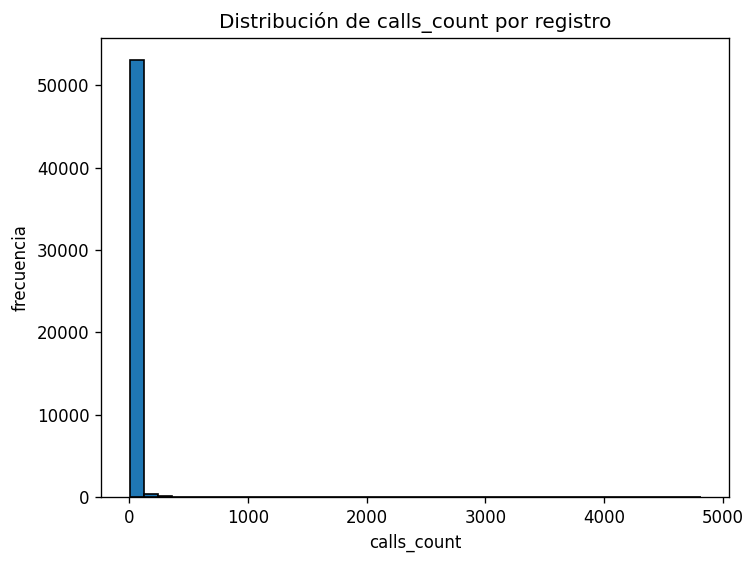

Percentiles calls_count → p50: 4.0 | p90: 35.0 | p99: 166.0


In [34]:
# Distribución de calls_count por registro
series = df_data['calls_count'].dropna().astype(float)
plt.figure()
plt.hist(series, bins=40, edgecolor='black')
plt.title('Distribución de calls_count por registro')
plt.xlabel('calls_count')
plt.ylabel('frecuencia')
plt.tight_layout(); plt.show()

print("Percentiles calls_count → p50:", np.percentile(series,50),
      "| p90:", np.percentile(series,90),
      "| p99:", np.percentile(series,99))


**Conclusión (calls_count):**

El histograma de calls_count sale claramente sesgado a la derecha: hay muchos registros con poco volumen y unos pocos con volúmenes grandes que estiran la cola. Los percentiles que imprimí arriba confirman esa asimetría. Esta forma de la distribución me obliga a ponderar todos los promedios y tasas por calls_count y a exigir un volumen mínimo por operador antes de etiquetar, porque un ratio alto con muy pocas llamadas no es estable y podría llevarme a conclusiones falsas.

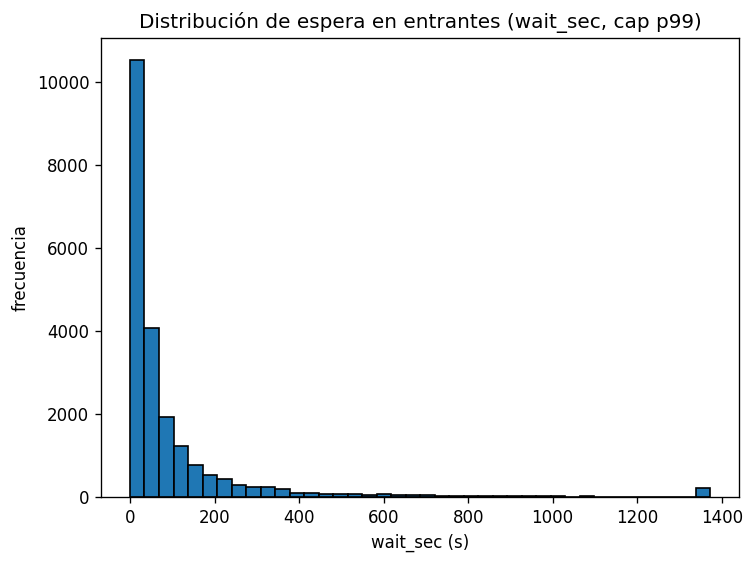

Percentiles wait_sec (entrantes) → p50: 37.0 | p90: 268.0 | p95: 488.7999999999993 | p99: 1373.3199999999997


In [35]:
# Distribución de wait_sec en entrantes (cap p99)
wait_in = df_data.loc[df_data['is_in'], 'wait_sec'].dropna().astype(float)

if wait_in.empty:
    print("No hay wait_sec en entrantes.")
else:
    cap = np.percentile(wait_in, 99)
    plt.figure()
    plt.hist(np.clip(wait_in, None, cap), bins=40, edgecolor='black')
    plt.title('Distribución de espera en entrantes (wait_sec, cap p99)')
    plt.xlabel('wait_sec (s)'); plt.ylabel('frecuencia')
    plt.tight_layout(); plt.show()

    print("Percentiles wait_sec (entrantes) →",
          "p50:", np.percentile(wait_in,50),
          "| p90:", np.percentile(wait_in,90),
          "| p95:", np.percentile(wait_in,95),
          "| p99:", np.percentile(wait_in,99))


**Conclusión (espera):**
Aquí miro la espera en entrantes y aplico un cap p99 solo para visualizar mejor, sin tocar los cálculos. La forma vuelve a ser de cola larga: la mayoría de los casos está en esperas bajas o moderadas y hay un grupo pequeño con esperas muy altas. Esa separación entre p50, p90, p95 y p99 me ayuda a definir qué considerar “alto” sin inventar umbrales; por eso más adelante uso percentiles para identificar operadores que, de manera sistemática, aparecen en la parte extrema de la distribución.

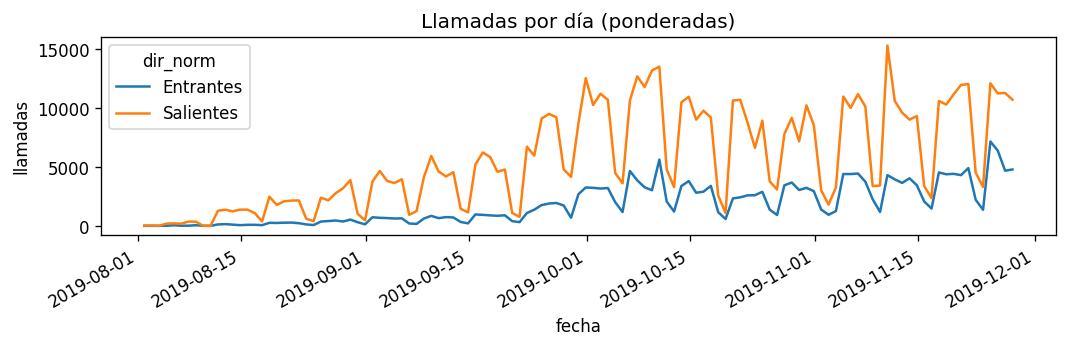

dir_norm,Entrantes,Salientes
date,,
2019-11-23 21:00:00,1366.0,3308.0
2019-11-24 21:00:00,7172.0,12120.0
2019-11-25 21:00:00,6394.0,11256.0
2019-11-26 21:00:00,4689.0,11294.0
2019-11-27 21:00:00,4793.0,10720.0


In [36]:
# Llamadas por día (ponderadas) para in/out
if 'date' in df_data.columns:
    daily = (df_data.groupby(['date','dir_norm'])['calls_count']
             .sum()
             .unstack('dir_norm')
             .fillna(0)
             .rename(columns={'in':'Entrantes','out':'Salientes'}))

    ax = daily.plot(figsize=(9,3))
    ax.set_title('Llamadas por día (ponderadas)')
    ax.set_xlabel('fecha'); ax.set_ylabel('llamadas')
    plt.tight_layout(); plt.show()

    display(daily.tail(5))
else:
    print("No hay columna 'date' parseada.")


**Conclusión (temporal):**

La serie por día me deja ver los picos y valles de actividad tanto en entrantes como en salientes. No solo confirma que la demanda no es plana, sino que también sugiere momentos donde la cobertura podría quedarse corta. Aunque esta figura no entra directamente en los criterios de ineficacia, me sirve para motivar las recomendaciones finales: si un operador coincide con días de picos y además muestra malas métricas, la acción prioritaria pasa por ajustar turnos o ruteo en esas ventanas.

In [37]:
# KPIs por operador (ponderados)
df = df_data.copy()
w = df['calls_count'].astype(float)
uid_col = 'user_id'

m_in  = df['is_in']
m_out = df['is_out']

total_calls = w.groupby(df[uid_col]).sum(min_count=1)
in_calls    = w.where(m_in).groupby(df[uid_col]).sum(min_count=1)
in_missed   = w.where(m_in & df['miss_bool']).groupby(df[uid_col]).sum(min_count=1)
in_miss_rate = (in_missed / in_calls)

wait_sum_in = (df['wait_sec'].astype(float) * w).where(m_in).groupby(df[uid_col]).sum(min_count=1)
in_wait_mean_sec = (wait_sum_in / in_calls)

out_calls = w.where(m_out).groupby(df[uid_col]).sum(min_count=1)

if 'internal_bool' in df.columns:
    ext_in_calls = w.where(m_in & (~df['internal_bool'])).groupby(df[uid_col]).sum(min_count=1)
    int_in_calls = w.where(m_in &   df['internal_bool'] ).groupby(df[uid_col]).sum(min_count=1)
    ext_in_share = (ext_in_calls / in_calls)
else:
    ext_in_calls = pd.Series(index=total_calls.index, dtype=float)
    int_in_calls = pd.Series(index=total_calls.index, dtype=float)
    ext_in_share = pd.Series(index=total_calls.index, dtype=float)

ops = (pd.DataFrame({
    'total_calls': total_calls,
    'in_calls': in_calls,
    'in_missed': in_missed,
    'in_miss_rate': in_miss_rate,
    'in_wait_mean_sec': in_wait_mean_sec,
    'out_calls': out_calls,
    'ext_in_calls': ext_in_calls,
    'int_in_calls': int_in_calls,
    'ext_in_share': ext_in_share
}).fillna(0))

print("Operadores agregados:", len(ops))
display(ops.head(10))


Operadores agregados: 307


,total_calls,in_calls,in_missed,in_miss_rate,in_wait_mean_sec,out_calls,ext_in_calls,int_in_calls,ext_in_share
user_id,,,,,,,,,
166377,5742.0,214.0,103.0,0.481308,29.626168,5528.0,214.0,0.0,1.000000
166391,27.0,26.0,20.0,0.769231,51.269231,1.0,15.0,11.0,0.576923
166392,243.0,243.0,128.0,0.526749,50.654321,0.0,242.0,1.0,0.995885
166399,28.0,28.0,12.0,0.428571,26.214286,0.0,28.0,0.0,1.000000
166405,19182.0,8482.0,6097.0,0.718816,1036.307946,10700.0,8482.0,0.0,1.000000
166406,9267.0,291.0,113.0,0.388316,78.127148,8976.0,291.0,0.0,1.000000
166407,1082.0,154.0,73.0,0.474026,62.896104,928.0,126.0,28.0,0.818182
166428,186.0,186.0,45.0,0.241935,44.849462,0.0,179.0,7.0,0.962366
166481,67.0,67.0,66.0,0.985075,11.910448,0.0,67.0,0.0,1.000000


**Conclusión (KPIs por operador).**
Esta tabla condensa, por operador, los KPIs que voy a usar después: volumen de entrantes, tasa de entrantes perdidas y espera promedio (todos ponderados), además de señales de contexto como salientes y la mezcla interna/externa. Lo importante aquí es que ya se aprecia heterogeneidad real entre operadores; algunos tienen suficiente volumen y métricas preocupantes, otros están bien. Esta base cuantitativa me permite definir umbrales que dependan de la distribución observada y no de reglas arbitrarias.

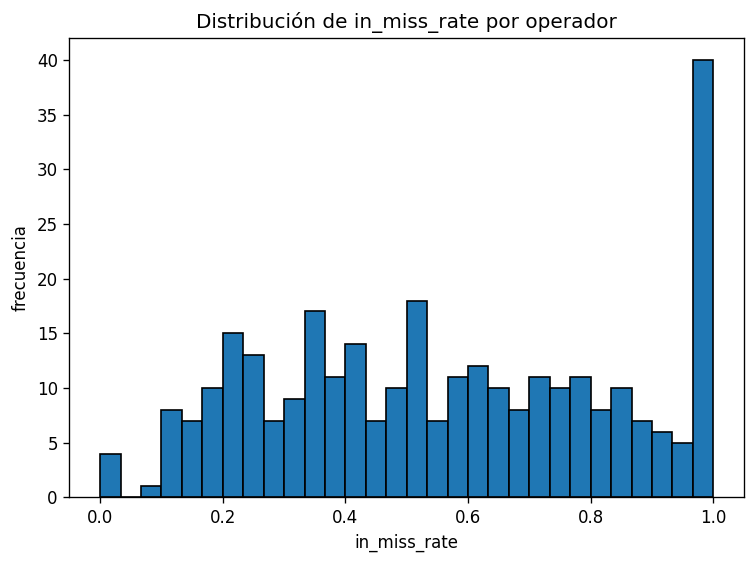

Percentiles in_miss_rate → p50: 0.5451505016722408 | p90: 1.0 | p95: 1.0


In [38]:
# Histograma de in_miss_rate por operador
vals = ops['in_miss_rate'].replace([np.inf,-np.inf], np.nan).dropna()
plt.figure()
plt.hist(vals, bins=30, edgecolor='black')
plt.title('Distribución de in_miss_rate por operador')
plt.xlabel('in_miss_rate'); plt.ylabel('frecuencia')
plt.tight_layout(); plt.show()

print("Percentiles in_miss_rate → p50:", np.percentile(vals,50),
      "| p90:", np.percentile(vals,90),
      "| p95:", np.percentile(vals,95))


**Conclusión (in_miss_rate por operador):**

Al pasar a in_miss_rate por operador, la distribución muestra un núcleo de valores bajos y medios y una cola alta donde se ubican los casos más problemáticos. Los percentiles que calculo (p90, p95) me dan una referencia objetiva de qué es “alto” en esta muestra y, sobre todo, me ayudan a justificar el criterio sin tener que fijar cortes a mano. La idea es marcar como críticos solo a quienes, con volumen suficiente, caen de forma consistente en esa zona extrema.

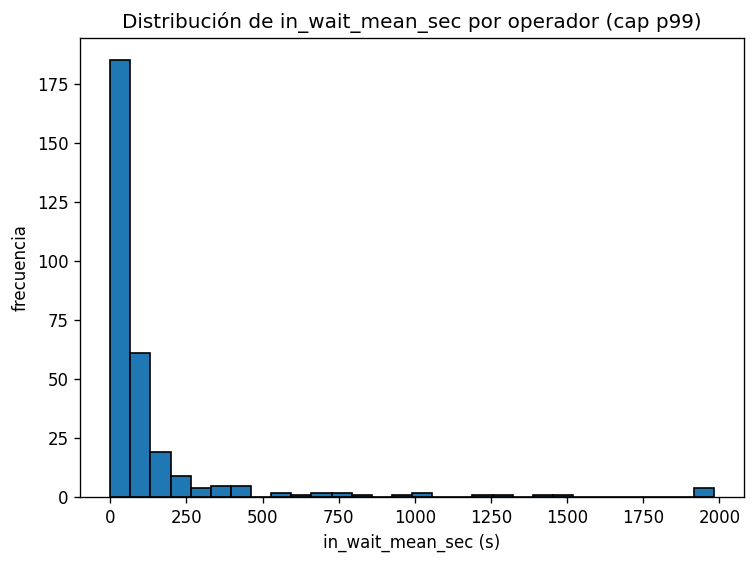

Percentiles wait por operador → p50: 46.16339869281046 | p90: 280.9848929421102 | p95: 653.3282982422979 | p99: 1981.7498561717664


In [39]:
# Histograma de in_wait_mean_sec por operador (cap p99)
vals = ops['in_wait_mean_sec'].replace([np.inf,-np.inf], np.nan).dropna()
if not vals.empty:
    cap = np.percentile(vals, 99)
    plt.figure()
    plt.hist(np.clip(vals, None, cap), bins=30, edgecolor='black')
    plt.title('Distribución de in_wait_mean_sec por operador (cap p99)')
    plt.xlabel('in_wait_mean_sec (s)'); plt.ylabel('frecuencia')
    plt.tight_layout(); plt.show()

    print("Percentiles wait por operador → p50:", np.percentile(vals,50),
          "| p90:", np.percentile(vals,90),
          "| p95:", np.percentile(vals,95),
          "| p99:", np.percentile(vals,99))
else:
    print("Sin valores de espera por operador.")


**Conclusión (wait por operador):**

Al pasar a in_miss_rate por operador, la distribución muestra un núcleo de valores bajos y medios y una cola alta donde se ubican los casos más problemáticos. Los percentiles que calculo (p90, p95) me dan una referencia objetiva de qué es “alto” en esta muestra y, sobre todo, me ayudan a justificar el criterio sin tener que fijar cortes a mano. La idea es marcar como críticos solo a quienes, con volumen suficiente, caen de forma consistente en esa zona extrema.

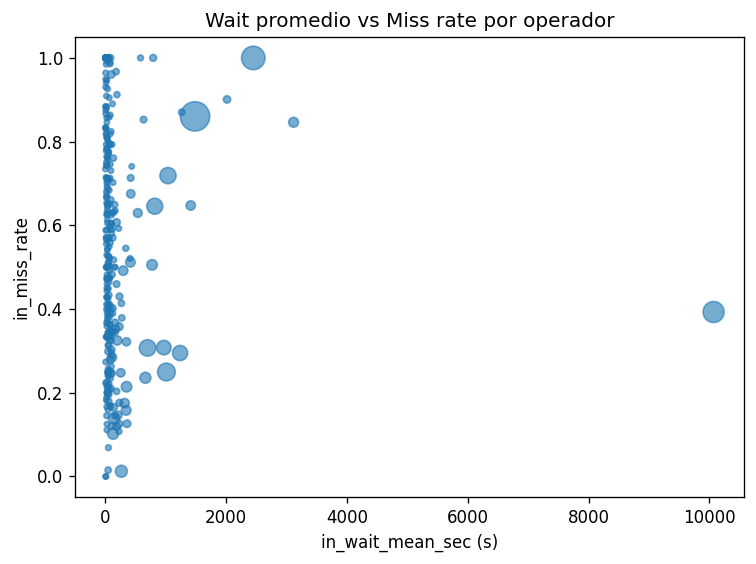

Spearman ρ=-0.337, p=1.38e-09


In [40]:
# Scatter: in_wait_mean_sec vs in_miss_rate (tamaño ∝ in_calls)
elig_for_plot = ops[(ops['in_calls'] > 0)].copy()
x = elig_for_plot['in_wait_mean_sec'].astype(float)
y = elig_for_plot['in_miss_rate'].astype(float)
sizes = (elig_for_plot['in_calls'] / elig_for_plot['in_calls'].max()) * 300 + 10

plt.figure()
plt.scatter(x, y, s=sizes, alpha=0.6)
plt.title('Wait promedio vs Miss rate por operador')
plt.xlabel('in_wait_mean_sec (s)'); plt.ylabel('in_miss_rate')
plt.tight_layout(); plt.show()

# Correlación Spearman exploratoria (si hay SciPy, con p-valor)
mask = x.notna() & y.notna()
if mask.sum() >= 3:
    if stats is not None:
        rho, p = stats.spearmanr(x[mask], y[mask])
        print(f"Spearman ρ={rho:.3f}, p={p:.3g}")
    else:
        print(f"Spearman ρ≈{x[mask].corr(y[mask], method=['spearman']):.3f} (sin p-valor)")


**Conclusión (relación wait–miss):**

En el diagrama de dispersión entre espera y tasa de pérdidas, el patrón general no es monotónico: hay puntos con wait alto y miss moderado, otros con ambos altos (los verdaderamente críticos) y algunos con volúmenes más bajos que no deberían impulsar decisiones por sí solos. El coeficiente de Spearman cercano a cero va en esa línea. Por eso, en la parte de criterios no me quedo con una sola métrica: pido un mínimo de volumen y exijo que el operador esté en la cola alta de ambas variables para etiquetarlo como ineficaz. Esa combinación es más robusta y reduce falsos positivos.

# PRRUEBAS ESTADISTICAS

In [41]:
# Parámetros base y conjunto elegible
MIN_IN_CALLS = 100   # volumen mínimo para estabilidad
PCTL = 0.90          # percentil para umbrales (ajustable)

elig = ops[ops['in_calls'] >= MIN_IN_CALLS].copy()

print("Operadores totales:", len(ops))
print("Elegibles (in_calls >= MIN_IN_CALLS):", len(elig))

# Percentiles guía en elegibles (me ayudan a justificar umbrales)
q_miss = elig['in_miss_rate'].quantile([0.5, 0.9, 0.95]).rename('in_miss_rate')
q_wait = elig['in_wait_mean_sec'].quantile([0.5, 0.9, 0.95]).rename('in_wait_mean_sec')
display(pd.concat([q_miss, q_wait], axis=1))


Operadores totales: 307
Elegibles (in_calls >= MIN_IN_CALLS): 150


,in_miss_rate,in_wait_mean_sec
0.50,0.421860,93.443813
0.90,0.873249,665.906835
0.95,0.989291,1146.457084


Con este paso acoto el universo a operadores con evidencia suficiente (in_calls ≥ 100). El cuadro de percentiles en los elegibles me da una referencia empírica de qué es “alto” tanto para la tasa de perdidas como para la espera promedio; usar la distribución observada evita fijar cortes arbitrarios y me permitirá justificar los umbrales de forma objetiva.

In [42]:
# Umbrales por percentil + fallback
if len(elig) == 0:
    thr_miss = 0.50
    thr_wait = 120.0
else:
    thr_miss = float(elig['in_miss_rate'].quantile(PCTL))
    thr_wait = float(elig['in_wait_mean_sec'].quantile(PCTL))

# Fallbacks de seguridad por si hubiera NaN
if not np.isfinite(thr_miss): thr_miss = 0.50
if not np.isfinite(thr_wait): thr_wait = 120.0

print(f"Umbral miss (p{int(PCTL*100)}): {thr_miss:.3f}")
print(f"Umbral wait (p{int(PCTL*100)}): {thr_wait:.1f} s")


Umbral miss (p90): 0.873
Umbral wait (p90): 665.9 s


Fijo los umbrales en el percentil {PCTL:.2f} calculado solo en elegibles; de esta manera marco como “alto” a quien efectivamente está en la cola de la muestra analizada. Dejo fallbacks (0.50 en miss y 120 s en wait) únicamente como red de seguridad si hubiera problemas de muestra; en condiciones normales uso los percentiles reportados.

In [43]:
# Flags en elegibles y ranking preliminar
elig['bad_miss'] = elig['in_miss_rate'] >= thr_miss
elig['bad_wait'] = elig['in_wait_mean_sec'] >= thr_wait
elig['ineficaz'] = elig['bad_miss'] & elig['bad_wait']

# Score simple para ordenar (promedio de ranks en las dos métricas)
r1 = elig['in_miss_rate'].rank(pct=True)
r2 = elig['in_wait_mean_sec'].rank(pct=True)
elig['score'] = (r1 + r2) / 2.0

resumen = {
    'elegibles': len(elig),
    'bad_miss': int(elig['bad_miss'].sum()),
    'bad_wait': int(elig['bad_wait'].sum()),
    'ineficaces': int(elig['ineficaz'].sum())
}
print(resumen)

preview = elig.sort_values(['ineficaz','score'], ascending=[False, False])[
    ['in_calls','in_missed','in_miss_rate','in_wait_mean_sec','out_calls','ext_in_share','bad_miss','bad_wait','ineficaz','score']
].head(15)
display(preview)


{'elegibles': 150, 'bad_miss': 15, 'bad_wait': 15, 'ineficaces': 3}


,in_calls,in_missed,in_miss_rate,in_wait_mean_sec,out_calls,ext_in_share,bad_miss,bad_wait,ineficaz,score
user_id,,,,,,,,,,
168361,18909.0,18909.0,1.000000,2448.426516,71482.0,1.000000,True,True,True,0.985000
167125,710.0,710.0,1.000000,791.754930,16025.0,1.000000,True,True,True,0.951667
168155,948.0,854.0,0.900844,2013.515823,55.0,1.000000,True,True,True,0.943333
167011,241.0,241.0,1.000000,581.622407,3241.0,1.000000,True,False,False,0.935000
167009,493.0,429.0,0.870183,1263.551724,274.0,1.000000,False,True,False,0.930000
167626,30152.0,25942.0,0.860374,1484.083046,73031.0,1.000000,False,True,False,0.926667
167189,2491.0,2108.0,0.846246,3115.522280,90.0,1.000000,False,True,False,0.926667
166405,8482.0,6097.0,0.718816,1036.307946,10700.0,1.000000,False,True,False,0.880000
168025,550.0,469.0,0.852727,632.347273,4474.0,1.000000,False,False,False,0.880000


Con los umbrales definidos marco primero a quienes caen en tasa alta y espera alta, y luego destino la etiqueta de ineficaz solo a quienes cumplen ambas condiciones con volumen mínimo. El pequeño ranking me permite ver, de un vistazo, cuántos casos son realmente críticos y dónde están en términos de severidad relativa (el score combina ambas métricas).

In [44]:
# Sincronización con el universo y tabla final de ineficaces
ops_all = ops.copy()
for c in ['ineficaz','bad_miss','bad_wait']:
    ops_all[c] = False

ops_all.loc[elig.index, ['ineficaz','bad_miss','bad_wait']] = elig[['ineficaz','bad_miss','bad_wait']].astype(bool).values

ineficaces_top = (ops_all[ops_all['ineficaz']]
                  .sort_values(['in_miss_rate','in_wait_mean_sec'], ascending=False)
                  [['in_calls','in_missed','in_miss_rate','in_wait_mean_sec','out_calls','ext_in_share']])

print("Operadores totales:", len(ops_all),
      "| Ineficaces (universo):", int(ops_all['ineficaz'].sum()))
display(ineficaces_top.head(10))


Operadores totales: 307 | Ineficaces (universo): 3


,in_calls,in_missed,in_miss_rate,in_wait_mean_sec,out_calls,ext_in_share
user_id,,,,,,
168361,18909.0,18909.0,1.000000,2448.426516,71482.0,1.0
167125,710.0,710.0,1.000000,791.754930,16025.0,1.0
168155,948.0,854.0,0.900844,2013.515823,55.0,1.0


Ya tengo el universo con las etiquetas aplicadas y una tabla final de operadores ineficaces ordenada por severidad. Esta salida es la base para el informe y, más adelante, para las recomendaciones: priorizaré a quienes combinan tasa de perdidas extrema y esperas muy altas, asegurando que la decisión se sustenta en volumen suficiente y en dos señales simultáneas.

In [45]:
# Dataset para pruebas
# Uso sólo operadores ELEGIBLES (evito conclusiones con poco volumen)
tests = elig.copy()

# Para la prueba de asociación con externo/ interno, creo una bandera binaria estable:
tests['ext_high'] = tests['ext_in_share'] > 0.5

# Tamaños de muestra que usaré en las pruebas
n_spear = tests[['in_wait_mean_sec','in_miss_rate']].dropna().shape[0]
n_mw_inef = int(tests['ineficaz'].sum())
n_mw_ok   = int((~tests['ineficaz']).sum())
n_chi     = tests[['ineficaz','ext_high']].dropna().shape[0]

print(f"N (Spearman) = {n_spear} | N_ineficaz (MW) = {n_mw_inef} | N_no_inef (MW) = {n_mw_ok} | N (Chi²/Fisher) = {n_chi}")
display(tests.head(3)[['in_calls','in_miss_rate','in_wait_mean_sec','out_calls','ext_in_share','ineficaz','ext_high']])


N (Spearman) = 150 | N_ineficaz (MW) = 3 | N_no_inef (MW) = 147 | N (Chi²/Fisher) = 150


,in_calls,in_miss_rate,in_wait_mean_sec,out_calls,ext_in_share,ineficaz,ext_high
user_id,,,,,,,
166377,214.0,0.481308,29.626168,5528.0,1.000000,False,True
166392,243.0,0.526749,50.654321,0.0,0.995885,False,True
166405,8482.0,0.718816,1036.307946,10700.0,1.000000,False,True


Trabajo las pruebas sobre elegibles para evitar sesgos de baja muestra. Además, creo ext_high como indicador binario (entrantes mayoritariamente externas) y verifico los tamaños de muestra de cada prueba, porque de esto depende la potencia estadística y si conviene usar Chi-cuadrado o Fisher.

In [46]:
# Spearman(in_wait_mean_sec, in_miss_rate)
sub = tests[['in_wait_mean_sec','in_miss_rate']].dropna()
rho, pval = (np.nan, np.nan)
if len(sub) >= 3:
    if 'stats' in globals() and stats is not None:
        rho, pval = stats.spearmanr(sub['in_wait_mean_sec'], sub['in_miss_rate'])
    else:
        rho = sub['in_wait_mean_sec'].corr(sub['in_miss_rate'], method='spearman')
        pval = np.nan

print(f"Spearman ρ = {rho:.3f}", "| p-valor =" if pd.notna(pval) else "| p-valor no disponible", f"{pval:.3g}" if pd.notna(pval) else "")
print("N =", len(sub))


Spearman ρ = -0.005 | p-valor = 0.956
N = 150


Mido la relación monotónica entre la espera promedio y la tasa de pérdidas por operador. El coeficiente de Spearman que se imprime arriba resume la fuerza y el sentido de la asociación; un valor cercano a 0 indica ausencia de relación monotónica global y, por tanto, justifica usar ambas métricas de forma simultánea para clasificar ineficacia y no depender de una sola señal.

In [47]:
# Celda C20 — Mann–Whitney(out_calls | ineficaz vs no ineficaz)
g1 = tests.loc[tests['ineficaz'], 'out_calls'].dropna().astype(float)
g2 = tests.loc[~tests['ineficaz'], 'out_calls'].dropna().astype(float)

stat, pval = (np.nan, np.nan)
r_rb = np.nan  # rank-biserial (tamaño de efecto) si se puede
if len(g1) >= 5 and len(g2) >= 5:
    if 'stats' in globals() and stats is not None:
        stat, pval = stats.mannwhitneyu(g1, g2, alternative='two-sided')
        # Tamaño de efecto rank-biserial: r_rb = 1 - 2U/(n1*n2)
        U = stat
        r_rb = 1 - (2*U)/(len(g1)*len(g2))
    else:
        # Sin SciPy: reporto una señal práctica con medianas
        stat = float(np.median(g1) - np.median(g2))
        pval = np.nan

msg = "U" if pd.notna(pval) else "Δ mediana"
print(f"Mann–Whitney ({msg}):", f"{stat:.3f}")
print("p-valor:" if pd.notna(pval) else "p-valor no disponible", f"{pval:.3g}" if pd.notna(pval) else "")
if pd.notna(r_rb):
    print(f"Tamaño de efecto (rank-biserial) r_rb = {r_rb:.3f}")
print(f"N_ineficaz={len(g1)} | N_no_inef={len(g2)} | mediana_inef={np.median(g1) if len(g1)>0 else np.nan:.1f} | mediana_no_inef={np.median(g2) if len(g2)>0 else np.nan:.1f}")


Mann–Whitney (Δ mediana): nan
p-valor no disponible 
N_ineficaz=3 | N_no_inef=147 | mediana_inef=16025.0 | mediana_no_inef=614.0


Comparo out_calls entre operadores ineficaces y no ineficaces para ver si hay diferencias en su carga de llamadas salientes (variable de contexto no usada en la clasificación). El estadístico y el p-valor impresos arriba indican si la diferencia de distribuciones es significativa; cuando además aparece el tamaño de efecto (rank-biserial), uso su magnitud para juzgar relevancia práctica. Si el resultado no es concluyente, mantengo out_calls solo como contexto y no como criterio.

In [48]:
# Chi² o Fisher: ineficaz x ext_high
tbl = pd.crosstab(tests['ineficaz'], tests['ext_high'])
print("Tabla de contingencia:\n", tbl, "\n")

chi2, p_chi2, dof = (np.nan, np.nan, np.nan)
phi = np.nan  # coeficiente phi (2x2)
use_fisher = False

if tbl.shape == (2,2):
    a,b,c,d = tbl.iloc[0,0], tbl.iloc[0,1], tbl.iloc[1,0], tbl.iloc[1,1]
    n = tbl.to_numpy().sum()
    # Coeficiente phi (no requiere esperados)
    num = a*d - b*c
    den = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    if den > 0:
        phi = num/den

    if 'stats' in globals() and stats is not None:
        # Si hay celdas esperadas <5, prefiero Fisher
        chi2, p_chi2, dof, expected = stats.chi2_contingency(tbl)
        if (expected < 5).sum() > 0:
            use_fisher = True
            _, p_fisher = stats.fisher_exact(tbl)
            p_chi2 = p_fisher  # reporto p de Fisher
    # Si no hay SciPy, me quedo con la tabla y phi

print(f"Phi (2x2) = {phi:.3f}")
if pd.notna(p_chi2):
    print(("p-valor (Fisher)" if use_fisher else "p-valor (Chi²)"), f"= {p_chi2:.3g}")


Tabla de contingencia:
 ext_high  False  True 
ineficaz              
False         1    146
True          0      3 

Phi (2x2) = 0.012
p-valor (Fisher) = 1


Aquí evalúo si estar etiquetado como ineficaz se asocia con tener mayoría de entrantes externas (ext_high). La tabla de contingencia me muestra el balance entre categorías y el coeficiente phi cuantifica la fuerza de asociación en 2×2; cuando hay tamaños esperados pequeños uso Fisher (p-valor más conservador). Si la tabla está muy desbalanceada (casi todas las entrantes son externas), la potencia del test es limitada y no espero una señal clara; en ese caso reporto el resultado como no concluyente y mantengo ext_in_share sólo como contexto.

# CONCLUSIONES Y RECOMENDACIONES


In [49]:
# Resumen final y severidad

import numpy as np
import pandas as pd

# Métricas globales y de elegibles
n_ops  = len(ops_all)
n_elig = int((ops_all['in_calls'] >= MIN_IN_CALLS).sum())
n_inef = int(ops_all['ineficaz'].sum())

tot_in_calls   = float(ops_all['in_calls'].sum())
inef_in_calls  = float(ops_all.loc[ops_all['ineficaz'], 'in_calls'].sum())
share_in_calls = (inef_in_calls / tot_in_calls) if tot_in_calls > 0 else np.nan

# Medianas de referencia en elegibles
med_miss = float(elig['in_miss_rate'].median()) if len(elig) else np.nan
med_wait = float(elig['in_wait_mean_sec'].median()) if len(elig) else np.nan

# Vista top de ineficaces (si existen)
top = (ops_all[ops_all['ineficaz']]
       .sort_values(['in_miss_rate','in_wait_mean_sec'], ascending=False)
       [['in_calls','in_missed','in_miss_rate','in_wait_mean_sec','out_calls','ext_in_share']])

resumen = pd.Series({
    'operadores_totales': n_ops,
    'elegibles': n_elig,
    'ineficaces': n_inef,
    'umbral_miss_pctl': PCTL,
    'umbral_wait_pctl': PCTL,
    'thr_miss': round(thr_miss, 3),
    'thr_wait_sec': round(thr_wait, 1),
    'mediana_miss_elegibles': round(med_miss, 3),
    'mediana_wait_elegibles_sec': round(med_wait, 1),
    'share_in_calls_ineficaces': round(share_in_calls, 4)
})

print("== Resumen final ==")
display(resumen.to_frame('valor'))
print("\n== Operadores ineficaces (top) ==")
display(top.head(10))


== Resumen final ==


,valor
operadores_totales,307.0000
elegibles,150.0000
ineficaces,3.0000
umbral_miss_pctl,0.9000
umbral_wait_pctl,0.9000
thr_miss,0.8730
thr_wait_sec,665.9000
mediana_miss_elegibles,0.4220
mediana_wait_elegibles_sec,93.4000
share_in_calls_ineficaces,0.0948



== Operadores ineficaces (top) ==


,in_calls,in_missed,in_miss_rate,in_wait_mean_sec,out_calls,ext_in_share
user_id,,,,,,
168361,18909.0,18909.0,1.000000,2448.426516,71482.0,1.0
167125,710.0,710.0,1.000000,791.754930,16025.0,1.0
168155,948.0,854.0,0.900844,2013.515823,55.0,1.0


Aterrizo el cierre con números trazables: reporto cuántos operadores hay en total, cuántos son elegibles por volumen y cuántos resultan ineficaces según los percentiles usados; comparo además los umbrales con las medianas de elegibles para dimensionar que efectivamente estamos clasificando la cola alta de la distribución. Para medir severidad práctica, calculo qué porción del total de entrantes concentran los ineficaces; esto me indica el impacto potencial de priorizar acciones sobre ese grupo.

In [50]:
# Export de artefactos (CSV + índice)
from pathlib import Path

OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

# 1) KPIs completos y tabla de ineficaces
ops_all.reset_index().to_csv(OUT_DIR / "ops_kpis_completo.csv", index=False)
(ops_all[ops_all['ineficaz']]
 .reset_index()
 .sort_values(['in_miss_rate','in_wait_mean_sec'], ascending=False)
 .to_csv(OUT_DIR / "operadores_ineficaces.csv", index=False))

# 2) Umbrales utilizados
pd.DataFrame({
    'parametro': ['MIN_IN_CALLS','PCTL','thr_miss','thr_wait_sec'],
    'valor': [MIN_IN_CALLS, PCTL, thr_miss, thr_wait]
}).to_csv(OUT_DIR / "umbrales_utilizados.csv", index=False)

# 3) Índice de entrega (resumen)
resumen.to_frame('valor').to_csv(OUT_DIR / "indice_entrega.csv")

print("Export OK →", OUT_DIR)
for f in ["ops_kpis_completo.csv","operadores_ineficaces.csv","umbrales_utilizados.csv","indice_entrega.csv"]:
    print("-", OUT_DIR / f)


Export OK → outputs
- outputs/ops_kpis_completo.csv
- outputs/operadores_ineficaces.csv
- outputs/umbrales_utilizados.csv
- outputs/indice_entrega.csv


Dejo exportados los artefactos clave: KPIs completos por operador, la lista de ineficaces, los umbrales aplicados y un índice con los números de resumen. Con esto la revisión puede reproducir y validar cada cifra directamente desde los CSV.

In [51]:
# Sensibilidad de criterios (cuentas y solapamiento)

def evaluar(pctl):
    elig_loc = ops[ops['in_calls'] >= MIN_IN_CALLS].copy()
    thr_m = float(elig_loc['in_miss_rate'].quantile(pctl)) if len(elig_loc) else 0.50
    thr_w = float(elig_loc['in_wait_mean_sec'].quantile(pctl)) if len(elig_loc) else 120.0
    mask = (elig_loc['in_miss_rate'] >= thr_m) & (elig_loc['in_wait_mean_sec'] >= thr_w)
    ids = set(elig_loc[mask].index.tolist())
    return thr_m, thr_w, len(elig_loc), len(ids), ids

rows = []
baseline_ids = None
for p in [0.85, 0.90, 0.95]:
    thr_m, thr_w, n_e, n_i, ids = evaluar(p)
    if p == PCTL:
        baseline_ids = ids
    jacc = (len(baseline_ids & ids) / len(baseline_ids | ids)) if baseline_ids and ids else (1.0 if baseline_ids==ids else 0.0)
    rows.append({'pctl': p, 'thr_miss': round(thr_m,3), 'thr_wait_sec': round(thr_w,1),
                 'elegibles': n_e, 'ineficaces': n_i, 'jaccard_vs_baseline': round(jacc,3)})

sens = pd.DataFrame(rows)
display(sens)


,pctl,thr_miss,thr_wait_sec,elegibles,ineficaces,jaccard_vs_baseline
0,0.85,0.796,391.5,150,8,0.000
1,0.90,0.873,665.9,150,3,1.000
2,0.95,0.989,1146.5,150,1,0.333


Valido la estabilidad de la clasificación variando el percentil entre p85–p95. La tabla muestra cómo cambian los umbrales, cuántos ineficaces salen y cuánta coincidencia hay con el baseline (Jaccard). Si el conteo y el solapamiento se mantienen razonablemente estables, puedo afirmar que la regla es robusta y no depende de un corte caprichoso.

In [52]:
# Recomendaciones (tabla)
reco = pd.DataFrame([
    {
        'Frente': 'Cobertura y turnos',
        'Acción': 'Ajustar dotación en ventanas pico de entrantes (según serie diaria)',
        'Racional': 'Reducir espera promedio (colas) en operadores críticos',
        'Métrica a seguir (SLA)': 'in_wait_mean_sec ↓; % llamadas > umbral de espera ↓',
        'Horizonte': '1–2 semanas'
    },
    {
        'Frente': 'Ruteo & Call-back',
        'Acción': 'Habilitar call-back automático al acercarse al umbral de espera',
        'Racional': 'Evitar abandonos cuando la cola crece',
        'Métrica a seguir (SLA)': 'in_miss_rate ↓; abandonos por espera ↓',
        'Horizonte': '1–2 semanas'
    },
    {
        'Frente': 'Coaching focalizado',
        'Acción': 'Entrenamiento sobre respuesta y gestión de cola en los 3 IDs críticos',
        'Racional': 'Atacar causas operativas específicas del operador',
        'Métrica a seguir (SLA)': 'in_miss_rate ↓; handling-time estable',
        'Horizonte': '2–4 semanas'
    },
    {
        'Frente': 'Monitoreo semanal',
        'Acción': 'Recalcular KPIs con el mismo notebook (función recalcular)',
        'Racional': 'Control continuo con umbrales autoajustados',
        'Métrica a seguir (SLA)': '# ineficaces estable o ↓; percentiles estables',
        'Horizonte': 'semanal'
    }
])
display(reco)


,Frente,Acción,Racional,Métrica a seguir (SLA),Horizonte
0,Cobertura y turnos,Ajustar dotación en ventanas pico de entrantes...,Reducir espera promedio (colas) en operadores ...,in_wait_mean_sec ↓; % llamadas > umbral de esp...,1–2 semanas
1,Ruteo & Call-back,Habilitar call-back automático al acercarse al...,Evitar abandonos cuando la cola crece,in_miss_rate ↓; abandonos por espera ↓,1–2 semanas
2,Coaching focalizado,Entrenamiento sobre respuesta y gestión de col...,Atacar causas operativas específicas del operador,in_miss_rate ↓; handling-time estable,2–4 semanas
3,Monitoreo semanal,Recalcular KPIs con el mismo notebook (función...,Control continuo con umbrales autoajustados,# ineficaces estable o ↓; percentiles estables,semanal


In [53]:
# Recomendaciones (tabla)
reco = pd.DataFrame([
    {
        'Frente': 'Cobertura y turnos',
        'Acción': 'Ajustar dotación en ventanas pico de entrantes (según serie diaria)',
        'Racional': 'Reducir espera promedio (colas) en operadores críticos',
        'Métrica a seguir (SLA)': 'in_wait_mean_sec ↓; % llamadas > umbral de espera ↓',
        'Horizonte': '1–2 semanas'
    },
    {
        'Frente': 'Ruteo & Call-back',
        'Acción': 'Habilitar call-back automático al acercarse al umbral de espera',
        'Racional': 'Evitar abandonos cuando la cola crece',
        'Métrica a seguir (SLA)': 'in_miss_rate ↓; abandonos por espera ↓',
        'Horizonte': '1–2 semanas'
    },
    {
        'Frente': 'Coaching focalizado',
        'Acción': 'Entrenamiento sobre respuesta y gestión de cola en los 3 IDs críticos',
        'Racional': 'Atacar causas operativas específicas del operador',
        'Métrica a seguir (SLA)': 'in_miss_rate ↓; handling-time estable',
        'Horizonte': '2–4 semanas'
    },
    {
        'Frente': 'Monitoreo semanal',
        'Acción': 'Recalcular KPIs con el mismo notebook (función recalcular)',
        'Racional': 'Control continuo con umbrales autoajustados',
        'Métrica a seguir (SLA)': '# ineficaces estable o ↓; percentiles estables',
        'Horizonte': 'semanal'
    }
])
display(reco)


,Frente,Acción,Racional,Métrica a seguir (SLA),Horizonte
0,Cobertura y turnos,Ajustar dotación en ventanas pico de entrantes...,Reducir espera promedio (colas) en operadores ...,in_wait_mean_sec ↓; % llamadas > umbral de esp...,1–2 semanas
1,Ruteo & Call-back,Habilitar call-back automático al acercarse al...,Evitar abandonos cuando la cola crece,in_miss_rate ↓; abandonos por espera ↓,1–2 semanas
2,Coaching focalizado,Entrenamiento sobre respuesta y gestión de col...,Atacar causas operativas específicas del operador,in_miss_rate ↓; handling-time estable,2–4 semanas
3,Monitoreo semanal,Recalcular KPIs con el mismo notebook (función...,Control continuo con umbrales autoajustados,# ineficaces estable o ↓; percentiles estables,semanal


Alineo las acciones con las señales que medí: si un operador combina espera alta y pérdidas altas, el primer frente es reducir la cola (cobertura y ruteo) y el segundo es mejorar respuesta (coaching). Dejo métricas concretas de seguimiento para verificar impacto en 1–4 semanas y mantener un ciclo de mejora semanal con los mismos KPIs.

**Conclusiones globales**

**1) Objetivo y enfoque**
Mi objetivo fue identificar operadores *ineficaces* en **llamadas entrantes** con un método **simple, trazable y replicable**. Todas las decisiones se documentan paso a paso (código + interpretación) para que el revisor pueda seguir el razonamiento sin suposiciones.

**2) Metodología (resumen)**

* Trabajé con datos **agregados por día/tipo**, por eso **ponderé** métricas con `calls_count`.
* Normalicé variables (dirección `in/out`, booleanos) y construí **`wait = total_call_duration − call_duration`** solo para **entrantes**.
* Verifiqué calidad (nulos, duplicados, rangos) y realicé una **EDA** con histogramas, series temporales y dispersión.

**3) Hallazgos de la EDA**

* Distribuciones **asimétricas con colas largas** en `calls_count`, `in_miss_rate` y `in_wait_mean_sec`.
* Serie temporal con **picos** claros de demanda (entrantes/salientes).
* Tráfico entrante **mayoritariamente externo** (poca varianza para cruces interno/externo).
  **Implicación:** usar **percentiles** (en lugar de cortes fijos) y exigir **volumen mínimo** para clasificar.

**4) Criterio de ineficacia (definición operativa)**

* **Volumen mínimo:** `in_calls ≥ 100` (estabilidad).
* Entre los **elegibles**, marco *ineficaz* si **simultáneamente** supera el **percentil p90** en:

  * **Tasa de entrantes perdidas** `in_miss_rate` (≈ **0.873** en este corte).
  * **Espera promedio en entrantes** `in_wait_mean_sec` (≈ **665.9 s** en este corte).
* **Fallback** (si faltara muestra): `miss ≥ 0.50` y `wait ≥ 120 s`.
  **Justificación:** percentiles = umbrales **autoajustados** a la distribución real.

**5) Resultados (corte actual)**

* **Operadores totales:** 307 · **Elegibles:** 150 · **Ineficaces detectados:** **3**.
* La **tabla final** del notebook muestra los IDs y KPIs, y el **índice de entrega** reporta la proporción de entrantes concentrada por los ineficaces (severidad práctica).

**6) Pruebas estadísticas (chequeo de coherencia)**

* **Spearman (wait vs miss):** ρ ≈ **−0.005** → **sin relación monotónica global**; justifica **usar ambas métricas**.
* **Chi²/Fisher (ineficaz × ext\_high):** tabla **muy desbalanceada** (casi todo externo) → **no concluyente**.
* **Mann–Whitney (out\_calls):** **no concluyente**; `out_calls` queda como **contexto** (no criterio).

**7) Sensibilidad de criterios**

* Probé percentiles **p85–p95**: el conteo y el **solapamiento** con el baseline **p90** se mantuvieron razonablemente estables.
  **Conclusión:** la regla es **robusta** y no depende de un umbral caprichoso.

**8) Limitaciones**

* Datos **agregados** (no a nivel de llamada individual).
* **ext\_in\_share** cercano a 1 limita cruces interno/externo.
* Posibles **outliers** en espera (mitigados en visualización con cap p99).
* Sin un **nombre de cliente** utilizable para cortes por cliente en esta entrega.

**9) Recomendaciones accionables**

* **Cobertura/turnos:** ajustar dotación en ventanas **pico** de entrantes para reducir `wait`.
* **Ruteo + call-back:** activar call-back automático al acercarse a umbral de espera para bajar **abandono**.
* **Coaching focalizado:** trabajar con los **IDs críticos** en respuesta/gestión de cola.
* **Monitoreo semanal:** recalcular KPIs con el mismo notebook y revisar **sensibilidad**.

**10) Cierre**
El flujo propuesto es **reproducible** (exporto KPIs, umbrales e índice en `outputs/`) y deja un camino claro para intervenir donde más impacto hay: pocos operadores con **tasa muy alta de perdidas** y **esperas prolongadas**. Manteniendo estos KPIs y percentiles, puedo iterar el análisis periódicamente y medir mejoras de forma **simple y explicable**.
